# Globals

In [1]:
# Video preprocess
FRAMES_PER_SECOND = 24
FRAME_WIDTH = 224
FRAME_HEIGHT = 224

# Folder paths 
DATASET_PATH      ='./Visual/XD-Violence/'
NPY_RGB_FOLDER    ='./EXTRA/XD-Violence/rgb'
NPY_RGB2_FOLDER   ='./Visual/XD-Violence/rgb2'
NPY_FLOW_FOLDER   ='./EXTRA2/flow'
CHECKPOINT_FOLDER ='./Visual/checkpoint'
HISTORY_FOLDER    ='./Visual/checkpoint'


NPY_FILE_TYPE   = '.npy'
VIDEOS_FOLDER   = 'videos'
FRAMES_FOLDER   = 'frames'
FEATURES_FOLDER = 'features'
LABELS_PATH     = 'annotations'

# Fit default settings
EPOCHS = 50
BATCH_SIZE=32
SLIDING_WINDOW = 16

# Imports

In [2]:
# Useful
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #for disable gpu

import glob
import math
import warnings
import numpy as np
from abc import ABC
import pandas as pd
import random as rnd
from tqdm import tqdm
from datetime import datetime

# Tensorflow
import tensorflow as tf

# Keras
from keras import layers
from keras import backend as K
from keras.utils import Sequence
from keras import Model, optimizers
from keras.utils import to_categorical
from keras.utils.data_utils import get_file
from keras.models import load_model, Sequential
from keras.layers import (Activation, Dense, Input, BatchNormalization, concatenate,
                          Conv3D, MaxPooling3D, Dropout, Reshape, Lambda, Flatten)

# Video processing
import cv2

# Image show
from matplotlib import pyplot as plt

# Utils

In [3]:
"""
Utils module to provide some nice functions to develop with Keras and
Video sequences.
"""
def show_sample(generator, index=0, random=False, row_width=22, row_height=5):
    """ Displays a batch using matplotlib.

    params:

    - generator: keras video generator
    - index: integer index of batch to see (overriden if random is True)
    - random: boolean, if True, take a random batch from the generator
    - row_width: integer to give the figure height
    - row_height: integer that represents one line of image, it is multiplied by \
    the number of sample in batch.
    """
    total = len(generator)
    if random:
        sample = rnd.randint(0, total)
    else:
        sample = index

    assert index < len(generator)
    sample = generator[sample]
    sequences = sample[0]
    labels = sample[1]

    rows = len(sequences)

    index = 1
    plt.figure(figsize=(row_width, row_height*rows))
    for batchid, sequence in enumerate(sequences):
        classid = np.argmax(labels[batchid])
        classname = generator.dataset_labels_names[classid]
        cols = len(sequence)
        for image in sequence:
          if image.shape[2] == 2: #if optical flow
            hsv = np.zeros((224, 224, 3), dtype=np.uint8)
            hsv[:, :, 0] = 255
            hsv[:, :, 1] = 255

            mag, ang = cv2.cartToPolar(image[..., 0], image[..., 1])
            hsv[..., 0] = ang*180/np.pi/2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

            image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
          plt.subplot(rows, cols, index)
          plt.title(classname)
          plt.imshow(image)
          plt.axis('off')
          index += 1
    plt.show()

In [4]:
def show_sample_frames(frames, row_width=22, row_height=5):
  """ Displays a frames (array) using matplotlib.

  params:

  - frames: frames array
  - row_width: integer to give the figure height
  - row_height: integer that represents one line of image, it is multiplied by \
  the number of sample in batch.
"""
  rows = len(frames)

  index = 1
  plt.figure(figsize=(row_width, row_height*rows))
  for batchid, image in enumerate(frames):
    plt.subplot(rows, 6, index)
    plt.imshow(image)
    plt.axis('off')
    index += 1
  plt.show()

In [5]:
def get_video_name(video_file):
  """ Get video name by video file path
    
    params:
    
    - video_file: video file path
  """
  return os.path.splitext(os.path.basename(video_file))[0]

In [6]:
def crop_center_square(frame):
  """ Crop center of a frame (for augmentation)
    
    params:
    
    - frame: npy object of a frame
  """
  y, x, c = frame.shape
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y + min_dim, start_x:start_x + min_dim]

In [7]:
def select_frames(frames, index_slide=1, sliding_window=SLIDING_WINDOW):
  """ Select a certain number of frames determined by the number (sliding_window)
  
  :param frames: list of frames
  :param index_slide: the index of the sliding window
  :param sliding_window: number of frames to select
  :return: selection of frames (in side of the sliding window)
  """
  if index_slide*sliding_window + sliding_window > len(frames):
    # if the frames isn't divide by the sliding window and the index
    # pad the last frames with black frame
    frames_before_pad = frames[index_slide*sliding_window:]
    t = sliding_window - len(frames_before_pad)
    target = np.zeros((t, frames.shape[1], frames.shape[2], frames.shape[3]))
    frames_padded=np.append(frames_before_pad, target ,axis=0)
    return frames_padded
  
  frames_selected = frames[index_slide*sliding_window:][:sliding_window]
  return frames_selected

In [8]:
def ensure_folder_exists(folder_path):
  if not os.path.exists(folder_path):
    try:
      os.makedirs(folder_path)
    except OSError:
      print(f"Can't create destination directory {folder_path}!")

In [9]:
def normalize(arr, rescale=1/255):
  if arr.max() > 1:
    arr = arr/255
  return arr

In [10]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum()

In [11]:
def get_seconds(filepath, curr_fps, curr_sliding_window, index):
  """ Get from frame the curr second in the video
  
  :param filepath: file path of the video
  :param curr_fps: FPS  
  :param curr_sliding_window: the sliding window
  :param index: the index of the sliding window
  :return: the second of the frame in the video
  """
  video = cv2.VideoCapture(filepath)
  fps = video.get(cv2.CAP_PROP_FPS)
  frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

  sec = (index*curr_fps*curr_sliding_window)/fps

  return (int(math.ceil(sec)))

# Dataset

### Visual Features

#### Optical flow

In [12]:
#### Get Farneback Optical flow (dense optical flow)
def get_optical_flow(video_frames):
    """
    get_optical_flow -
    Optical flow is the pattern of apparent motion of image objects between two consecutive frames
    caused by the movement of object or camera.
    It is 2D vector field where each vector is a displacement vector showing the movement of points
    from first frame to second.
    
    :param video_frames: the input video with shape of [frames,height,width,channel]. dtype=np.array
    :return:  flows: the optical flows numpy array, with the shape of [frames,height,width,channel]
    """
    gray_frames = []
    flows = []

    for i in range(len(video_frames)):
      img_float32 = np.float32(video_frames[i])
      gray_frame = cv2.cvtColor(img_float32, cv2.COLOR_RGB2GRAY)
      gray_frames.append(np.reshape(gray_frame, (FRAME_HEIGHT, FRAME_WIDTH, 1)))

    for i in range(0, len(gray_frames) - 1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(prev=gray_frames[i], next=gray_frames[i + 1],
                                            flow=None, pyr_scale=0.5, levels=3,
                                            winsize=15, iterations=3, poly_n=5,
                                            poly_sigma=1.2, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0],None,0,255,cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1],None,0,255,cv2.NORM_MINMAX)
        # Add into list 
        flows.append(flow)

    # Padding the last frame as empty array
    return np.array(flows)

#### RGB

In [13]:
#### Get video frames
def video_to_frames(video_file_path: str, rescale=None, fps=FRAMES_PER_SECOND):
  """
  Convert a video file to individual frames
  
  :param video_file_path: the video path
  :param rescale: if rescaling the video (normalize)
  :param fps: frames per seconds
  
  :return: frames: rgb frames numpy array.
  """
  
  if os.path.exists(video_file_path) is None: 
    print(f'Error: file path - {video_file_path} not found')
    return

  # Load video capture stream
  cap = cv2.VideoCapture(video_file_path)

  # Video capture settings
  n_frames  = cap.get(cv2.CAP_PROP_FRAME_COUNT)  # Total number of frames
  f_width   = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # Width of the origin video
  f_height  = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # Height of the origin video
  f_rate    = cap.get(cv2.CAP_PROP_FPS)          # Get frame rate of video

  count = 0
  frames = []

  while cap.isOpened():
    frame_id = cap.get(1)         # current frame number
    success, frame = cap.read()   # if the frame is read correctly, it will be True
    if not success:
        break
    if frame is None:
        print(f'frame is none: {frame_id}')

    # We will save every fps that we defined
    if frame_id % math.floor(fps) == 0 or fps == 1:
        frame = cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH))  # Resize pixels
        frame = crop_center_square(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame.reshape(FRAME_HEIGHT, FRAME_WIDTH, 3) 

        if rescale:
          frame = frame * rescale
        
        frames.append(frame)

    count += 1

  # When everything is done, release the capture
  cap.release()

  return np.array(frames)

In [14]:
#### Video to npy array (rgb frames and flows)
def video_to_npy(video_file_path, fps=FRAMES_PER_SECOND):
    video_frames = video_to_frames(video_file_path=video_file_path, fps=fps)
    flows = get_optical_flow(video_frames)

    return video_frames, flows

### Dataset Builder

#### RGB Dataset

In [15]:
class VideoDataset(Sequence):
  """
  Create a generator that return batches of frames from video
  - dataset_path: string, the full path to the dataset folder
  - label_path: string, path to the classes file
  - save_npy: bool, save the npy file in the system (default:True)
  - batch_size: int, batch size for each loop
  - sliding_window: int, how many frames in each sliding_window to save
  - mode: string, the dataset mode (train/test) - used for accessing the dataset folders
  - kind: string, keras sequence defined the type of generator (train/test/validation)
  - shuffle: bool, randomize files
  - rescale: float fraction to rescale pixel data, normalization (commonly 1/255.)
  - fps: frames per second
  - split_val: float, precentage to split to validation data
  """
  def __init__(self, dataset_path: str, label_path: str, save_npy: bool = True,
               batch_size: int = BATCH_SIZE, sliding_window: int = SLIDING_WINDOW,  
               mode: str = 'train', kind:str = 'train', shuffle: bool = False, rescale=1/255.,
               fps:int = FRAMES_PER_SECOND, split_val: float = None, _validation_data = None):
    """ Get data structure to load data """
    
    self.rescale = rescale
    self.batch_size = batch_size
    self.sliding_window = sliding_window
    self.mode = mode
    kind = kind 
    self.shuffle = shuffle
    self.fps = fps
    self.save_npy = save_npy
    
    self.label_path = label_path
    self.dataset_path = dataset_path
    self.dataset_labels = {}
    self.dataset_labels_names = {}

    self.vid_info = []
    self.validation = []
    self.list_files= []
    self._framecounters = {}
    self._rgb_cache = {}
    
    # Get dataset files
    videos_directory = os.path.join(self.dataset_path, VIDEOS_FOLDER , self.mode)
    files = glob.glob(videos_directory+"/*.mp4")
    
    if _validation_data is not None:
      # we only need to set files here
      self.list_files = _validation_data
    else:
      # Split validation data
      # split factor should be a propoer value
      if split_val is not None:
        assert 0.0 < split_val < 1.0

      # then we don't need None anymore
      split_val = split_val if split_val is not None else 0.0

      if 0.0 < split_val < 1.0:
        # generate validation and test indexes
        indexes = np.arange(len(files))

        if shuffle:
            np.random.shuffle(indexes)

        nbval = int(split_val * len(files))
        nbtrain = len(files) - nbval

        # get some sample for validation_data
        val = np.random.permutation(indexes)[:nbval]

        # remove validation from train
        indexes = np.array([i for i in indexes if i not in val])
        self.validation += [files[i] for i in val]
        print(f'validation count:{nbval}')

        # and now, make the file list
        self.list_files += [files[i] for i in indexes]
      else:
        self.list_files = files
    
    if shuffle:
      np.random.shuffle(self.list_files)

    self.indexes = np.arange(len(self.list_files))
    
    # Get classes for dataset and initilized the labels
    with open(os.path.join(dataset_path, label_path), 'r') as f:
        for i, line in enumerate(f.readlines()):
            self.dataset_labels[i] = line.split('=')[0].strip()
            self.dataset_labels_names[i] = line.split('=')[1].strip()

    # Create an npy directory if the folder doesn't exist
    self.npy_rgb_directory = os.path.join(NPY_RGB_FOLDER, self.mode)
    self.npy_rgb2_directory = os.path.join(NPY_RGB2_FOLDER, self.mode)
    self.npy_flow_directory = os.path.join(NPY_FLOW_FOLDER, self.mode)

    ensure_folder_exists(self.npy_rgb_directory)
    ensure_folder_exists(self.npy_rgb2_directory)
    ensure_folder_exists(self.npy_flow_directory)

    print("Total data: %d classes for %d files for %s" % (
            len(self.dataset_labels),
            len(self.list_files),
            self.mode))
    
    self.__init_length()
    
  def get_validation_generator(self):
    """ Return the validation generator if you've provided split factor """
    return self.__class__(
      dataset_path=self.dataset_path,
      label_path=self.label_path,
      batch_size=self.batch_size,
      sliding_window=self.sliding_window,
      shuffle=self.shuffle,
      rescale=self.rescale,
      kind='validation',
      _validation_data=self.validation)
   
  def on_epoch_end(self):
    """ Called by Keras after each epoch """
    if self.shuffle:
        np.random.shuffle(self.indexes)
        
  def __len__(self):
    '''Denotes the number of batches per epoch'''
    return int(len(self.vid_info) // self.batch_size)

  def get_actual_len(self):
    """Denotes the total number of samples"""
    return len(self.list_files)
  
  def __getitem__(self, index):
    """Loading and preprocessing."""
    current_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    rgbs, labels = self._data_generation(current_indexes)

    return rgbs, labels
  
  def _data_generation(self, video_indexes):
    """ Get rgb and optical flow """
    # Initialization
    frames_batch = []
    labels_batch = []

    for video_index in video_indexes:
      try:
        vid = self.vid_info[video_index]
        video_file = vid.get('file_path')
        video_name = vid.get('video_name')
        video_rgb_npy_path = self.get_video_npy_path(video_name)
        video_rgb_npy_path2 = self.get_video_npy_path(video_name, folder=2)

        # Get video labels
        labels = self.get_video_labels(video_name)
        labels_batch.append(labels) 
        force_redo_npy=True
        
        # Get video frames and flows (had to split the path due to storage limits)
        if not self.save_npy and video_file in self._rgb_cache:
          frames = self._rgb_cache[video_file]
        elif os.path.isfile(video_rgb_npy_path + '_rgb.npy'):
          frames = np.load(video_rgb_npy_path + '_rgb.npy')
        elif os.path.isfile(video_rgb_npy_path2 + '_rgb.npy'):
          frames = np.load(video_rgb_npy_path2 + '_rgb.npy')
        else:
          frames = video_to_frames(video_file_path=video_file, fps=self.fps)
          
          # keep the result
          if self.save_npy:
            np.save(video_rgb_npy_path2 + '_rgb.npy', frames)
        if not self.save_npy:
          self._rgb_cache[video_file] = frames
        if self.rescale:
          frames = normalize(frames)

        vid_id = vid.get('vid_id')
        frames = select_frames(frames, vid_id, self.sliding_window)
        frames_batch.append(frames) 
      except Exception as e: 
        print('Exception: ', video_file)
        print(e)
        pass
    return np.array(frames_batch), np.array(labels_batch)
  
  def get_video_labels(self, video_file_name):
    """ Returns video labels - multiclass and multilabel by video file name (sepearted by '-')"""
    categories = video_file_name.split('_')[-1].split('-')
    video_labels = [k for k, v in self.dataset_labels.items() if v in categories]
    video_labels = to_categorical(video_labels, num_classes=len(self.dataset_labels), dtype="float32").sum(axis=0)
    video_labels = np.array(video_labels)

    return video_labels
  
  def get_video_npy_path(self, video_file_name, is_rgb=True, folder=1):
    """ Destination npy path """
    if is_rgb:
      if folder == 2:
        video_npy_path = os.path.join(self.npy_rgb2_directory, video_file_name)
      else:
        video_npy_path = os.path.join(self.npy_rgb_directory, video_file_name)
    else:
      video_npy_path = os.path.join(self.npy_flow_directory, video_file_name)
    return video_npy_path
  
  def count_frames(self, cap, video_file_path):
    """ Count number of frame for video
    if it's not possible with headers """
    if video_file_path in self._framecounters:
      return self._framecounters[video_file_path]

    # Video capture settings
    total  = cap.get(cv2.CAP_PROP_FRAME_COUNT)/self.fps +1  # Total number of frames
    
    # keep the result
    self._framecounters[video_file_path] = total
    return total

  def __init_length(self):
    count = 0
    print("Checking files to find possible sequences, please wait...")
    for filepath in self.list_files:
      cap = cv2.VideoCapture(filepath)
      frame_count = self.count_frames(cap, filepath)
      fps = cap.get(cv2.CAP_PROP_FPS)
      cap.release()
      
      seqtime = int(frame_count)
      # step = np.ceil(seqtime / self.sliding_window).astype(np.int) - 1
#       stop_at = int(seqtime - self.sliding_window)
      stop_at = math.ceil(seqtime / self.sliding_window)
      for i in range(stop_at):
        self.vid_info.append({
            'id': count,
            'file_path': filepath,
            'frame_count': int(frame_count),
            'vid_id': i,
            'fps': fps,
            'video_name': get_video_name(filepath)
        })
        count += 1

    print(f'For {len(self.list_files)} files, I found {len(self.vid_info)} possible sequence samples')
    self.indexes = np.arange(len(self.vid_info))

#### Optical Flow Dataset

In [16]:
class VideoFlowsDataset(VideoDataset):
  def __init__(
          self,
          *args,
          sliding_window=SLIDING_WINDOW,
          **kwargs):
      super().__init__(sliding_window=sliding_window, *args, **kwargs)

      self._flows_cache = {}
  def __getitem__(self, index):
    """Loading and preprocessing."""
    frames_batch, labels_batch = super().__getitem__(index)
    current_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    flows, labels = self._flows_generation(frames_batch, labels_batch, current_indexes)
  
    return flows, labels
  
  def _flows_generation(self, frames_batch, labels_batch, video_indexes):
    """ Get optical flows """
    # Initialization
    flows_batch = []

    for video_index in video_indexes:
      vid = self.vid_info[video_index]
      video_file = vid.get('file_path')
      video_name = vid.get('video_name')
      video_flow_npy_path = self.get_video_npy_path(video_name, is_rgb=False)
      video_rgb_npy_path = self.get_video_npy_path(video_name)
      video_rgb_npy_path2 = self.get_video_npy_path(video_name, folder=2)
      print(video_flow_npy_path + '_flows.npy')
      
      if not self.save_npy and video_file in self._flows_cache:
        flows = self._flows_cache[video_file]
      elif os.path.isfile(video_flow_npy_path + '_flows.npy'):
        flows = np.load(video_flow_npy_path + '_flows.npy')
      else:
        # Get video frames and flows 
        if os.path.isfile(video_rgb_npy_path + '_rgb.npy'):
          frames = np.load(video_rgb_npy_path + '_rgb.npy')
        elif os.path.isfile(video_rgb_npy_path2 + '_rgb.npy'):
          frames = np.load(video_rgb_npy_path2 + '_rgb.npy')
  
        try:
          if self.rescale:
            frames = normalize(frames)
          flows = get_optical_flow(frames)

        except Exception as e: 
          print(e)

        # keep the result
        if self.save_npy:
          np.save(video_flow_npy_path + '_flows.npy', flows)
        if not self.save_npy:
          self._flows_cache[video_file] = flows
        
      vid_id = vid.get('vid_id')
      flows_selected = select_frames(flows, vid_id, self.sliding_window)
      flows_batch.append(flows_selected) 
      
    return np.array(flows_batch), labels_batch

#### Test Dataset

In [62]:
class TestDataset(VideoFlowsDataset):
  def __init__( self,
                *args,
                test_labels_path,
               allow_rgbs=True,
               allow_flows=True,
                **kwargs):
    """ Get data structure to load data """
    self.test_labels_path = test_labels_path
    super().__init__(*args, **kwargs)

    self.videos_labels_times = {}
    self.allow_rgbs= allow_rgbs
    self.allow_flows = allow_flows
    
    # Get test dataset labels 
    # Get classes for dataset and initilized the labels
    with open(os.path.join(self.dataset_path, self.test_labels_path), 'r') as f:
      for i, line in enumerate(f.readlines()):
        annotation_split = line.split(' ')
        times = []

        # if video not already in video times dict
        filename=os.path.splitext(annotation_split[0])
        if filename not in self.videos_labels_times:
          for i in range(1, len(annotation_split)-1, 2):
            if (len(annotation_split) >= i+1):
              range_frames = (self.get_time_rounded(annotation_split[i]),
                              self.get_time_rounded(''.join(filter(str.isdigit, annotation_split[i+1]))))
            else: 
              range_frames = (self.get_time_rounded(annotation_split[i]), -1)
            times.append(range_frames) 
            
          self.videos_labels_times[filename] = times
          
  def on_epoch_end(self):
    'Updates indexes after each epoch' 
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def get_time_rounded(self, frame_count):
    return round(int(frame_count)/self.fps)

  def get_label_test(self, label, video_info):
    frame_id = video_info.get('vid_id')
    frame_count = video_info.get('frame_count')
    res = None 

    try:
      time_arr = self.videos_labels_times[video_info.get('video_name')]

      for idx, ele in enumerate(time_arr):
        if frame_id >= ele[0] and frame_id <= ele[1]:
          res = idx
    except Exception as e: 
      print(e)

    return res
          
  def __getitem__(self, index):
    """Loading and preprocessing."""
    current_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    
    rgbs, labels = self._data_generation(current_indexes)
    
    if self.allow_flows:
      flows, labels = self._flows_generation(frames_batch=rgbs,
                                             labels_batch=labels,
                                             video_indexes=current_indexes)

    for i, (label, video_index) in enumerate(zip(labels, current_indexes)):
      video_info = self.vid_info[video_index]
      vid_name = video_info.get('video_name')

      if label[0] != 1:  
        try:
          res = self.get_label_test(label, video_info)
          if res is None:
            labels[i] = [1,0,0,0,0,0,0]
        except Exception as e: 
          print('Exception', vid_name)
          print(e)
 
    if self.allow_rgbs and self.allow_flows:
      return rgbs, flows, labels
    elif self.allow_rgbs:
      return rgbs, labels
    elif self.allow_flows:
      return flows, labels

# Visual Model

## Base Model - I3D

In [18]:
WEIGHTS_NAME = ['rgb_kinetics_only',
                'flow_kinetics_only',
                'rgb_imagenet_and_kinetics',
                'flow_imagenet_and_kinetics']

# path to pretrained models with no top (no classification layer)
WEIGHTS_PATH_NO_TOP = {
    'rgb_kinetics_only': 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_kinetics_only': 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'rgb_imagenet_and_kinetics': 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_imagenet_and_kinetics': 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5'
}


def conv3d_bn(x,
              filters,
              num_frames,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1, 1),
              use_bias=False,
              use_activation_fn=True,
              use_bn=True,
              name=None):
  """Utility function to apply conv3d + BN.
  # Arguments
      x: input.
      filters: filters in `Conv3D`.
      num_frames: frames (time depth) of the convolution kernel.
      num_row: height of the convolution kernel.
      num_col: width of the convolution kernel.
      padding: padding mode in `Conv3D`.
      strides: strides in `Conv3D`.
      use_bias: use bias or not
      use_activation_fn: use an activation function or not.
      use_bn: use batch normalization or not.
      name: name of the ops; will become `name + '_conv'`
          for the convolution and `name + '_bn'` for the
          batch norm layer.
  # Returns
      Output tensor after applying `Conv3D` and `BatchNormalization`.
  """
  if name is not None:
    bn_name = name + '_bn'
    conv_name = name + '_conv'
  else:
    bn_name = None
    conv_name = None

  x = tf.keras.layers.Conv3D(
      filters, (num_frames, num_row, num_col),
      strides=strides,
      padding=padding,
      use_bias=use_bias,
      name=conv_name)(x)

  if use_bn:
    bn_axis = 4
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)

  if use_activation_fn:
    x = tf.keras.layers.Activation('relu', name=name)(x)

  return x


def Inception_Inflated3d(include_top=True,
                         weights=None,
                         input_tensor=None,
                         input_shape=None,
                         dropout_prob=0.0,
                         endpoint_logit=True,
                         classes=400):
  """Instantiates the Inflated 3D Inception architecture.
  Optionally loads weights pre-trained on Kinetics.
  Note that when using TensorFlow, for best performance you should set
  `image_data_format='channels_last'` in your Keras config at ~/.keras/keras.json.
  # Arguments
      include_top: whether to include the the classification
          layer at the top of the network.
      weights: one of `None` (random initialization)
          or 'kinetics_only' (pre-training on Kinetics dataset only).
          or 'imagenet_and_kinetics' (pre-training on ImageNet and Kinetics datasets).
      input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
          to use as image input for the model.
      input_shape: optional shape tuple, only to be specified
          if `include_top` is False (otherwise the input shape
          has to be `(NUM_FRAMES, 224, 224, 3)`
          NUM_FRAMES should be no smaller than 8. The authors used 64
          frames per example for training and testing on kinetics dataset
          Also, Width and height should be no smaller than 32.
          E.g. `(64, 150, 150, 3)` would be one valid value.
      dropout_prob: optional, dropout probability applied in dropout layer
          after global average pooling layer.
          0.0 means no dropout is applied, 1.0 means dropout is applied to all features.
          Note: Since Dropout is applied just before the classification
          layer, it is only useful when `include_top` is set to True.
      endpoint_logit: (boolean) optional. If True, the model's forward pass
          will end at producing logits. Otherwise, softmax is applied after producing
          the logits to produce the class probabilities prediction. Setting this parameter
          to True is particularly useful when you want to combine results of rgb model
          and optical flow model.
          - `True` end model forward pass at logit output
          - `False` go further after logit to produce softmax predictions
          Note: This parameter is only useful when `include_top` is set to True.
      classes: optional number of classes to classify images
          into, only to be specified if `include_top` is True, and
          if no `weights` argument is specified.
  # Returns
      A Keras model instance.
  # Raises
      ValueError: in case of invalid argument for `weights`,
          or invalid input shape.
  """
  if not (weights in WEIGHTS_NAME or weights is None or os.path.exists(weights)):
    raise ValueError('The `weights` argument should be either '
                       '`None` (random initialization) or %s' %
                       str(WEIGHTS_NAME) + ' '
                                           'or a valid path to a file containing `weights` values')

  if weights in WEIGHTS_NAME and include_top and classes != 400:
    raise ValueError('If using `weights` as one of these %s, with `include_top`'
                       ' as true, `classes` should be 400' % str(WEIGHTS_NAME))

  if input_tensor is None:
    img_input = tf.keras.layers.Input(shape=input_shape)
  else:
    if not K.is_keras_tensor(input_tensor):
      img_input = tf.keras.layers.Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

  channel_axis = 4

  # Downsampling via convolution (spatial and temporal)
  x = conv3d_bn(img_input, 64, 7, 7, 7, strides=(2, 2, 2), padding='same', name='Conv3d_1a_7x7')

  # Downsampling (spatial only)
  x = tf.keras.layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_2a_3x3')(x)
  x = conv3d_bn(x, 64, 1, 1, 1, strides=(1, 1, 1), padding='same', name='Conv3d_2b_1x1')
  x = conv3d_bn(x, 192, 3, 3, 3, strides=(1, 1, 1), padding='same', name='Conv3d_2c_3x3')

  # Downsampling (spatial only)
  x = tf.keras.layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_3a_3x3')(x)

  # Mixed 3b
  branch_0 = conv3d_bn(x, 64, 1, 1, 1, padding='same', name='Conv3d_3b_0a_1x1')

  branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_3b_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 128, 3, 3, 3, padding='same', name='Conv3d_3b_1b_3x3')

  branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_3b_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 32, 3, 3, 3, padding='same', name='Conv3d_3b_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3b_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 32, 1, 1, 1, padding='same', name='Conv3d_3b_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_3b')

  # Mixed 3c
  branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_0a_1x1')

  branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 192, 3, 3, 3, padding='same', name='Conv3d_3c_1b_3x3')

  branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_3c_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 96, 3, 3, 3, padding='same', name='Conv3d_3c_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3c_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_3c_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_3c')

  # Downsampling (spatial and temporal)
  x = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same', name='MaxPool2d_4a_3x3')(x)

  # Mixed 4b
  branch_0 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_4b_0a_1x1')

  branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_4b_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 208, 3, 3, 3, padding='same', name='Conv3d_4b_1b_3x3')

  branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_4b_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 48, 3, 3, 3, padding='same', name='Conv3d_4b_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4b_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4b_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4b')

  # Mixed 4c
  branch_0 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4c_0a_1x1')

  branch_1 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4c_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 224, 3, 3, 3, padding='same', name='Conv3d_4c_1b_3x3')

  branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4c_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4c_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4c_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4c_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4c')

  # Mixed 4d
  branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_0a_1x1')

  branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 256, 3, 3, 3, padding='same', name='Conv3d_4d_1b_3x3')

  branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4d_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4d_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4d_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4d_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4d')

  # Mixed 4e
  branch_0 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4e_0a_1x1')

  branch_1 = conv3d_bn(x, 144, 1, 1, 1, padding='same', name='Conv3d_4e_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 288, 3, 3, 3, padding='same', name='Conv3d_4e_1b_3x3')

  branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4e_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4e_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4e_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4e_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4e')

  # Mixed 4f
  branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_4f_0a_1x1')

  branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4f_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_4f_1b_3x3')

  branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4f_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_4f_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4f_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_4f_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4f')

  # Downsampling (spatial and temporal)
  x = tf.keras.layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same', name='MaxPool2d_5a_2x2')(x)

  # Mixed 5b
  branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_5b_0a_1x1')

  branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_5b_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_5b_1b_3x3')

  branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_5b_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5b_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5b_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5b_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_5b')

  # Mixed 5c
  branch_0 = conv3d_bn(x, 384, 1, 1, 1, padding='same', name='Conv3d_5c_0a_1x1')

  branch_1 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_5c_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 384, 3, 3, 3, padding='same', name='Conv3d_5c_1b_3x3')

  branch_2 = conv3d_bn(x, 48, 1, 1, 1, padding='same', name='Conv3d_5c_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5c_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5c_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5c_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_5c')

  if include_top:
    # Classification block
    x = tf.keras.layers.AveragePooling3D((2, 7, 7), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)
    x = tf.keras.layers.Dropout(dropout_prob)(x)

    x = conv3d_bn(x, classes, 1, 1, 1, padding='same',
                  use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')

    num_frames_remaining = int(x.shape[1])
    x = tf.keras.layers.Reshape((num_frames_remaining, classes))(x)

    # logits (raw scores for each class)
    x = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
                output_shape=lambda s: (s[0], s[2]))(x)

    if not endpoint_logit:
      x = tf.keras.layers.Activation('softmax', name='prediction')(x)
  else:
    h = int(x.shape[2])
    w = int(x.shape[3])
    x = tf.keras.layers.AveragePooling3D((2, h, w), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)

  inputs = img_input
  # create model
  model = tf.keras.Model(inputs, x, name='i3d_inception')

  # load weights
  if weights in WEIGHTS_NAME:
    if weights == WEIGHTS_NAME[0]:  # rgb_kinetics_only
      weights_url = WEIGHTS_PATH_NO_TOP['rgb_kinetics_only']
      model_name = 'i3d_inception_rgb_kinetics_only_no_top.h5'

    elif weights == WEIGHTS_NAME[1]:  # flow_kinetics_only
      weights_url = WEIGHTS_PATH_NO_TOP['flow_kinetics_only']
      model_name = 'i3d_inception_flow_kinetics_only_no_top.h5'

    elif weights == WEIGHTS_NAME[2]:  # rgb_imagenet_and_kinetics
      weights_url = WEIGHTS_PATH_NO_TOP['rgb_imagenet_and_kinetics']
      model_name = 'i3d_inception_rgb_imagenet_and_kinetics_no_top.h5'

    elif weights == WEIGHTS_NAME[3]:  # flow_imagenet_and_kinetics
      weights_url = WEIGHTS_PATH_NO_TOP['flow_imagenet_and_kinetics']
      model_name = 'i3d_inception_flow_imagenet_and_kinetics_no_top.h5'

    downloaded_weights_path = get_file(model_name, weights_url, cache_subdir='models')
    model.load_weights(downloaded_weights_path)

  elif weights is not None:
    model.load_weights(weights)

  return model

## Top

In [19]:
def add_i3d_top(base_model, classes) -> Model:
  """ Given an I3D model (without top layers), this function creates the top layers
  depending on the number of output classes, and returns the entire model.
  """
  classifier = base_model.output
  classifier = Flatten()(classifier)
  classifier = Dense(classes, activation='sigmoid')(classifier)

  new_model = tf.keras.Model(inputs=base_model.input, outputs=classifier, name="i3d_with_top")

  return new_model

## Get model

In [20]:
def layers_freeze(keras_model: Model) -> Model:
    for layer in keras_model.layers:
        layer.trainable = False

    return keras_model

  
def get_visual_model(input_shape, num_classes, type_model='rgb', with_top=True):
    # build model for optical flow data
    # and load pretrained weights (trained on imagenet and kinetics dataset)
    weights_name = f'{type_model}_imagenet_and_kinetics'
    i3d_model_without_top = Inception_Inflated3d(include_top=False,
                                                 weights=weights_name,
                                                 input_shape=input_shape,
                                                 classes=num_classes)
    i3d_model = layers_freeze(i3d_model_without_top)
    
    if with_top:
      i3d_model = add_i3d_top(i3d_model, num_classes)

      optimizer = optimizers.Adam(lr=1e-4, decay=1e-6)
      i3d_model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])    
    return i3d_model

## Concat Models

In [21]:
def concate_two_models(rgb_model, flow_model, classes=7):
  for layer in flow_model.layers:
    layer._name = layer.name + str("_flow")

  # combine the output of the two branches
  combined = concatenate([rgb_model.output, flow_model.output])
  
  # apply a FC layer and then a regression prediction on the
  # combined outputs
  classifier = Flatten()(combined)
  out = Dense(classes, activation='sigmoid', name='final_dense')(classifier)

  # our model will accept the inputs of the two branches and
  # then output a single value
  merged_model = Model(inputs=[rgb_model.input, flow_model.input], outputs=out)
  
  optimizer = optimizers.Adam(lr=1e-4, decay=1e-6)
  merged_model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy']) 
  
  return merged_model

# Create Datasets

In [23]:
violent_generator_rgb = VideoDataset(dataset_path=DATASET_PATH,
                                     label_path='class.txt',
                                     batch_size=8,
                                     sliding_window=16,
                                     shuffle=True,
                                     split_val=0.3)

validation count:876
Total data: 7 classes for 2044 files for train
Checking files to find possible sequences, please wait...
For 2044 files, I found 21148 possible sequence samples


In [24]:
violent_generator_flows = VideoFlowsDataset(dataset_path=DATASET_PATH,
                                            label_path='class.txt',
                                            batch_size=8,
                                            sliding_window=16,
                                            shuffle=True,
                                            split_val=0.3)

validation count:876
Total data: 7 classes for 2044 files for train
Checking files to find possible sequences, please wait...
For 2044 files, I found 21335 possible sequence samples


In [53]:
test_dataset_only_rgb = TestDataset(dataset_path=DATASET_PATH,
                           mode='test',
                           label_path='class.txt',
                           test_labels_path='annotations.txt',
                           batch_size=8,
                           fps=5,
                           sliding_window=16,
                           shuffle=False,
                          allow_flows=False)

Total data: 7 classes for 799 files for test
Checking files to find possible sequences, please wait...
For 799 files, I found 29634 possible sequence samples


In [26]:
test_dataset_only_flows = TestDataset(dataset_path=DATASET_PATH,
                           mode='test',
                           label_path='class.txt',
                           test_labels_path='annotations.txt',
                           batch_size=8,
                           fps=5,
                           sliding_window=16,
                           shuffle=False,
                          allow_rgbs=False)

Total data: 7 classes for 799 files for test
Checking files to find possible sequences, please wait...
For 799 files, I found 29634 possible sequence samples


In [27]:
vide_dataset = TestDataset(dataset_path=DATASET_PATH,
                           label_path='class.txt',
                           test_labels_path='annotations.txt',
                           batch_size=8,
                           fps=5,
                           sliding_window=16,
                           shuffle=True)

Total data: 7 classes for 2920 files for train
Checking files to find possible sequences, please wait...
For 2920 files, I found 140942 possible sequence samples


In [63]:
test_dataset = TestDataset(dataset_path=DATASET_PATH,
                           mode='test',
                           label_path='class.txt',
                           test_labels_path='annotations.txt',
                           batch_size=8,
                           fps=5,
                           sliding_window=16,
                           shuffle=True)

Total data: 7 classes for 799 files for test
Checking files to find possible sequences, please wait...
For 799 files, I found 29634 possible sequence samples


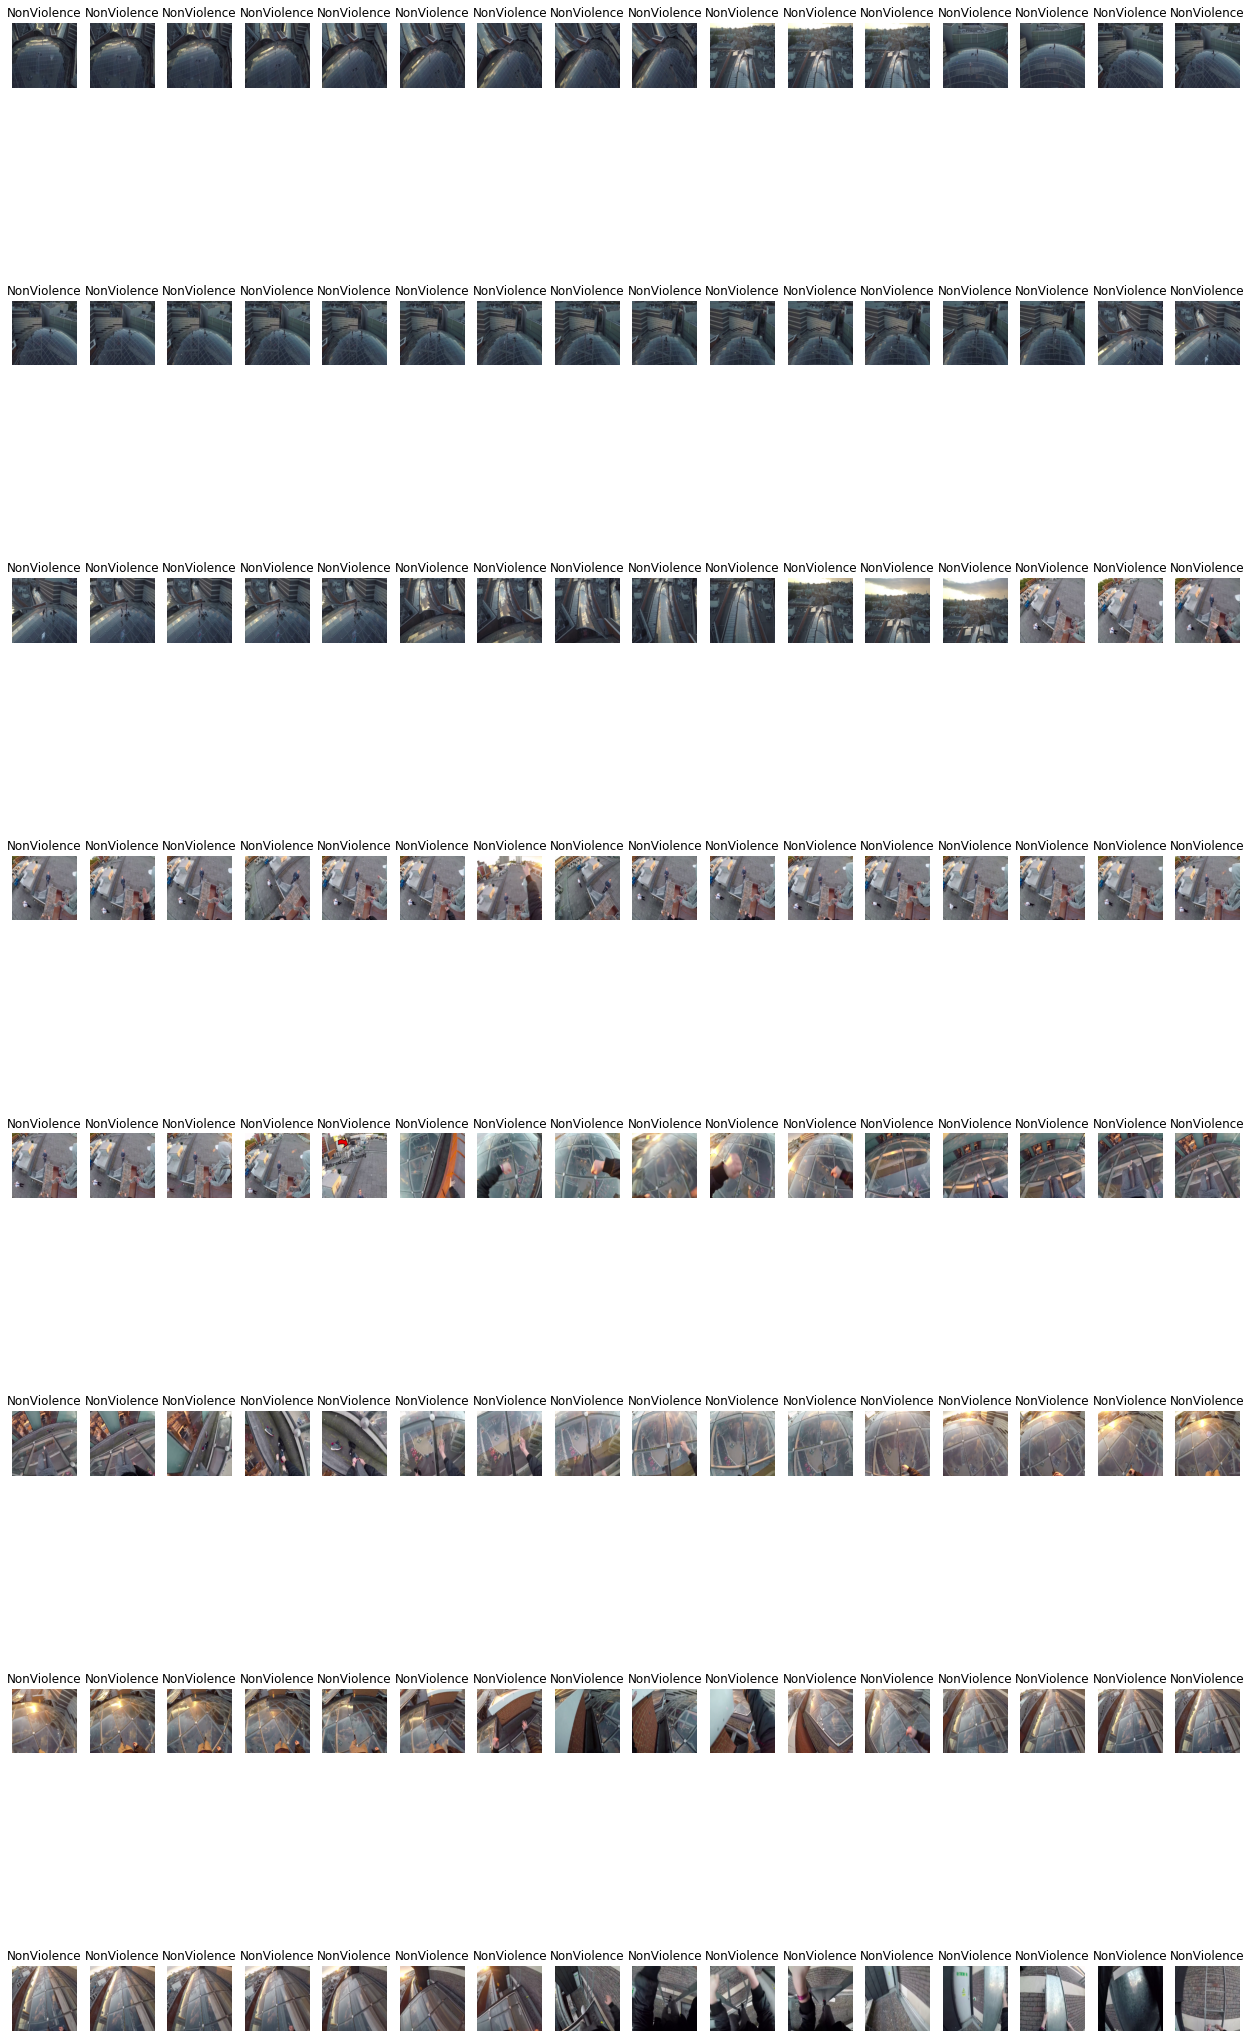

In [29]:
show_sample(violent_generator_rgb, index=1)

./EXTRA2/flow/train/v=MfgGJY_eZ4Q__#00-00-57_00-08-06_label_B4-0-0_flows.npy
./EXTRA2/flow/train/v=MfgGJY_eZ4Q__#00-00-57_00-08-06_label_B4-0-0_flows.npy
./EXTRA2/flow/train/v=MfgGJY_eZ4Q__#00-00-57_00-08-06_label_B4-0-0_flows.npy
./EXTRA2/flow/train/v=MfgGJY_eZ4Q__#00-00-57_00-08-06_label_B4-0-0_flows.npy
./EXTRA2/flow/train/v=MfgGJY_eZ4Q__#00-00-57_00-08-06_label_B4-0-0_flows.npy
./EXTRA2/flow/train/v=MfgGJY_eZ4Q__#00-00-57_00-08-06_label_B4-0-0_flows.npy
./EXTRA2/flow/train/v=MfgGJY_eZ4Q__#00-00-57_00-08-06_label_B4-0-0_flows.npy
./EXTRA2/flow/train/v=MfgGJY_eZ4Q__#00-00-57_00-08-06_label_B4-0-0_flows.npy


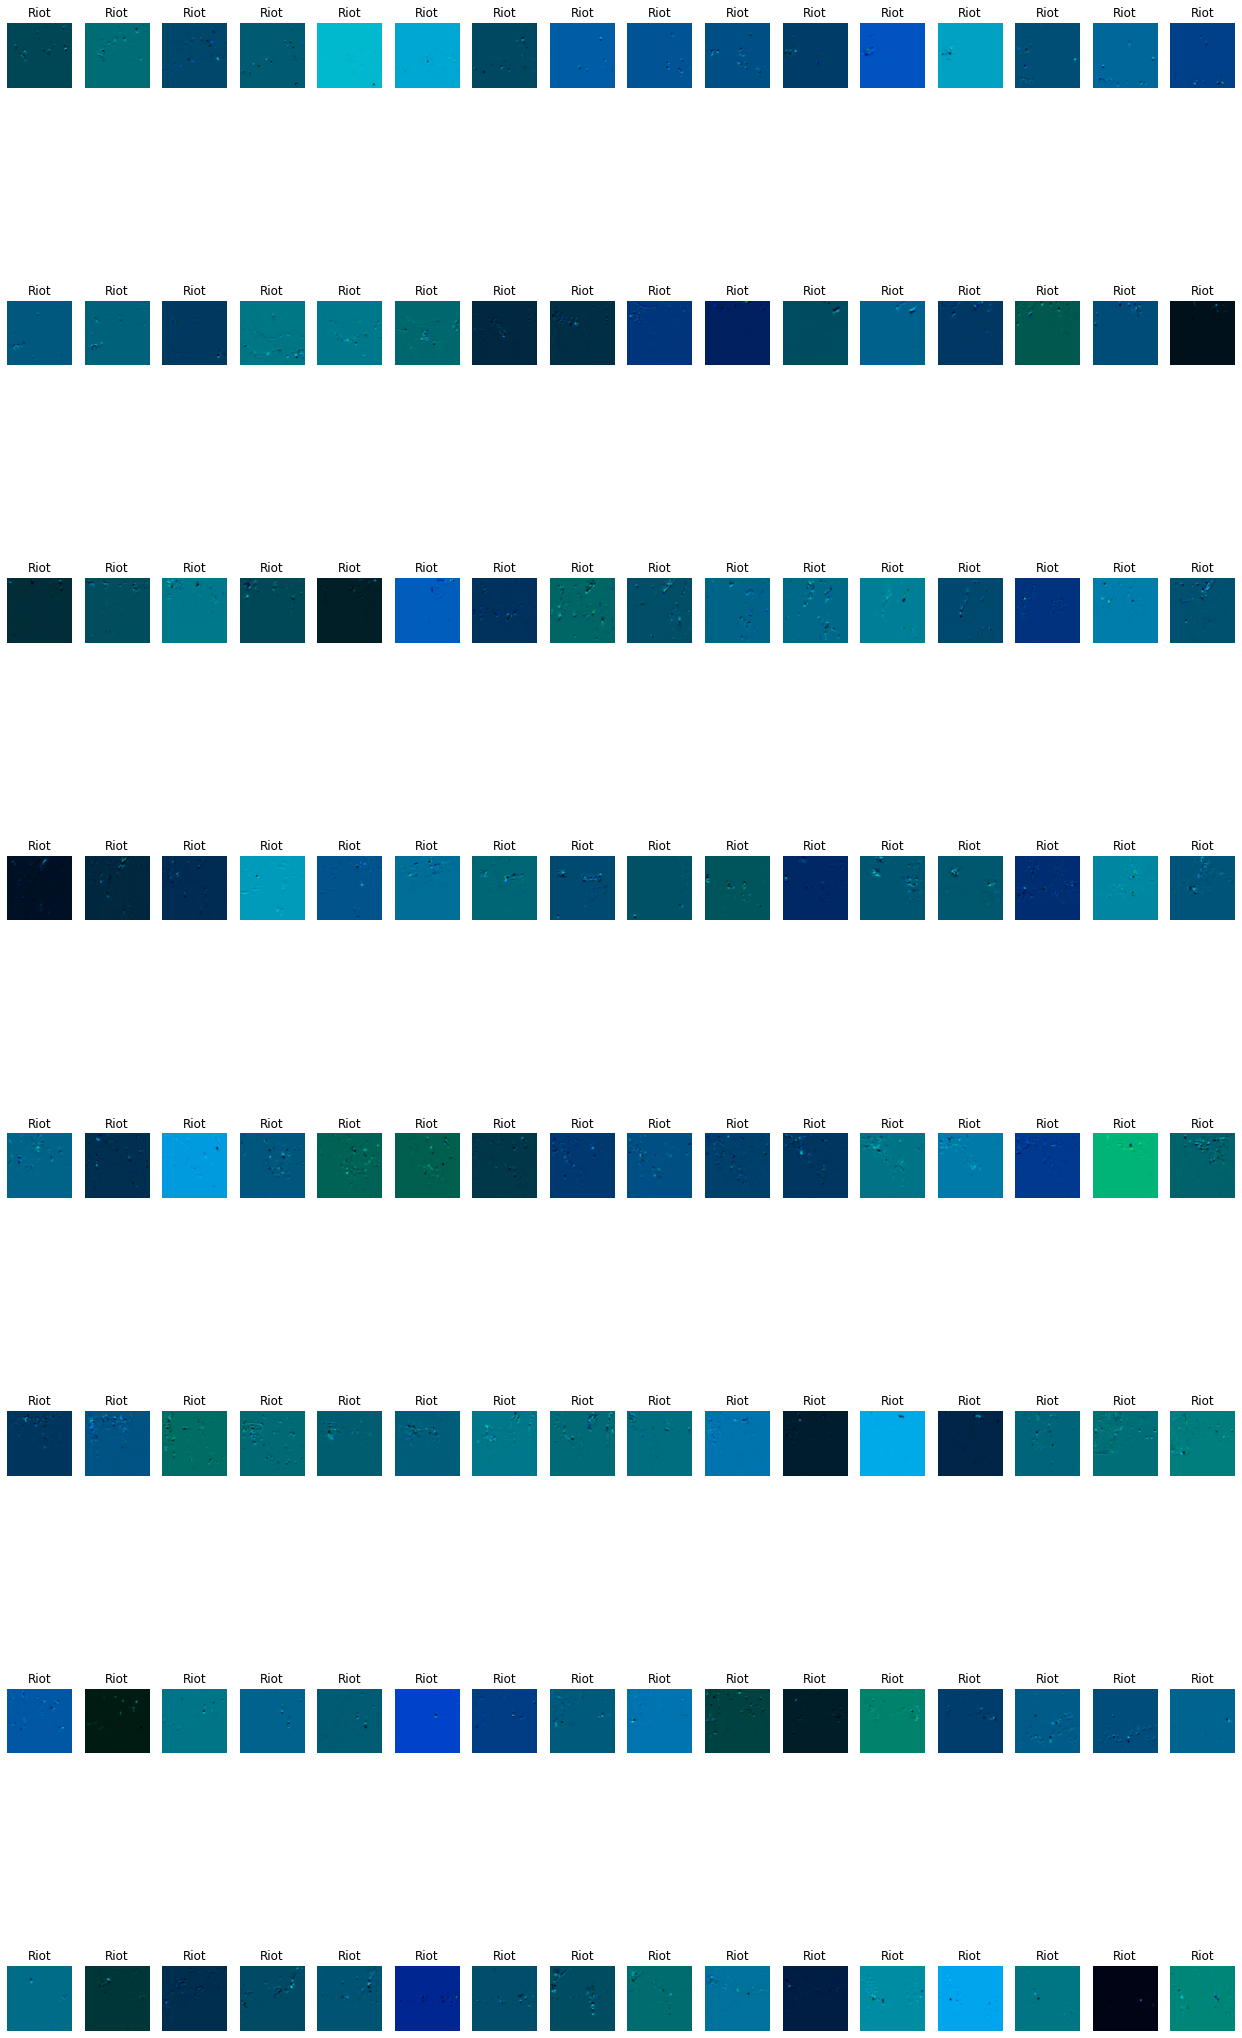

In [30]:
show_sample(violent_generator_flows, index=1)

'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'


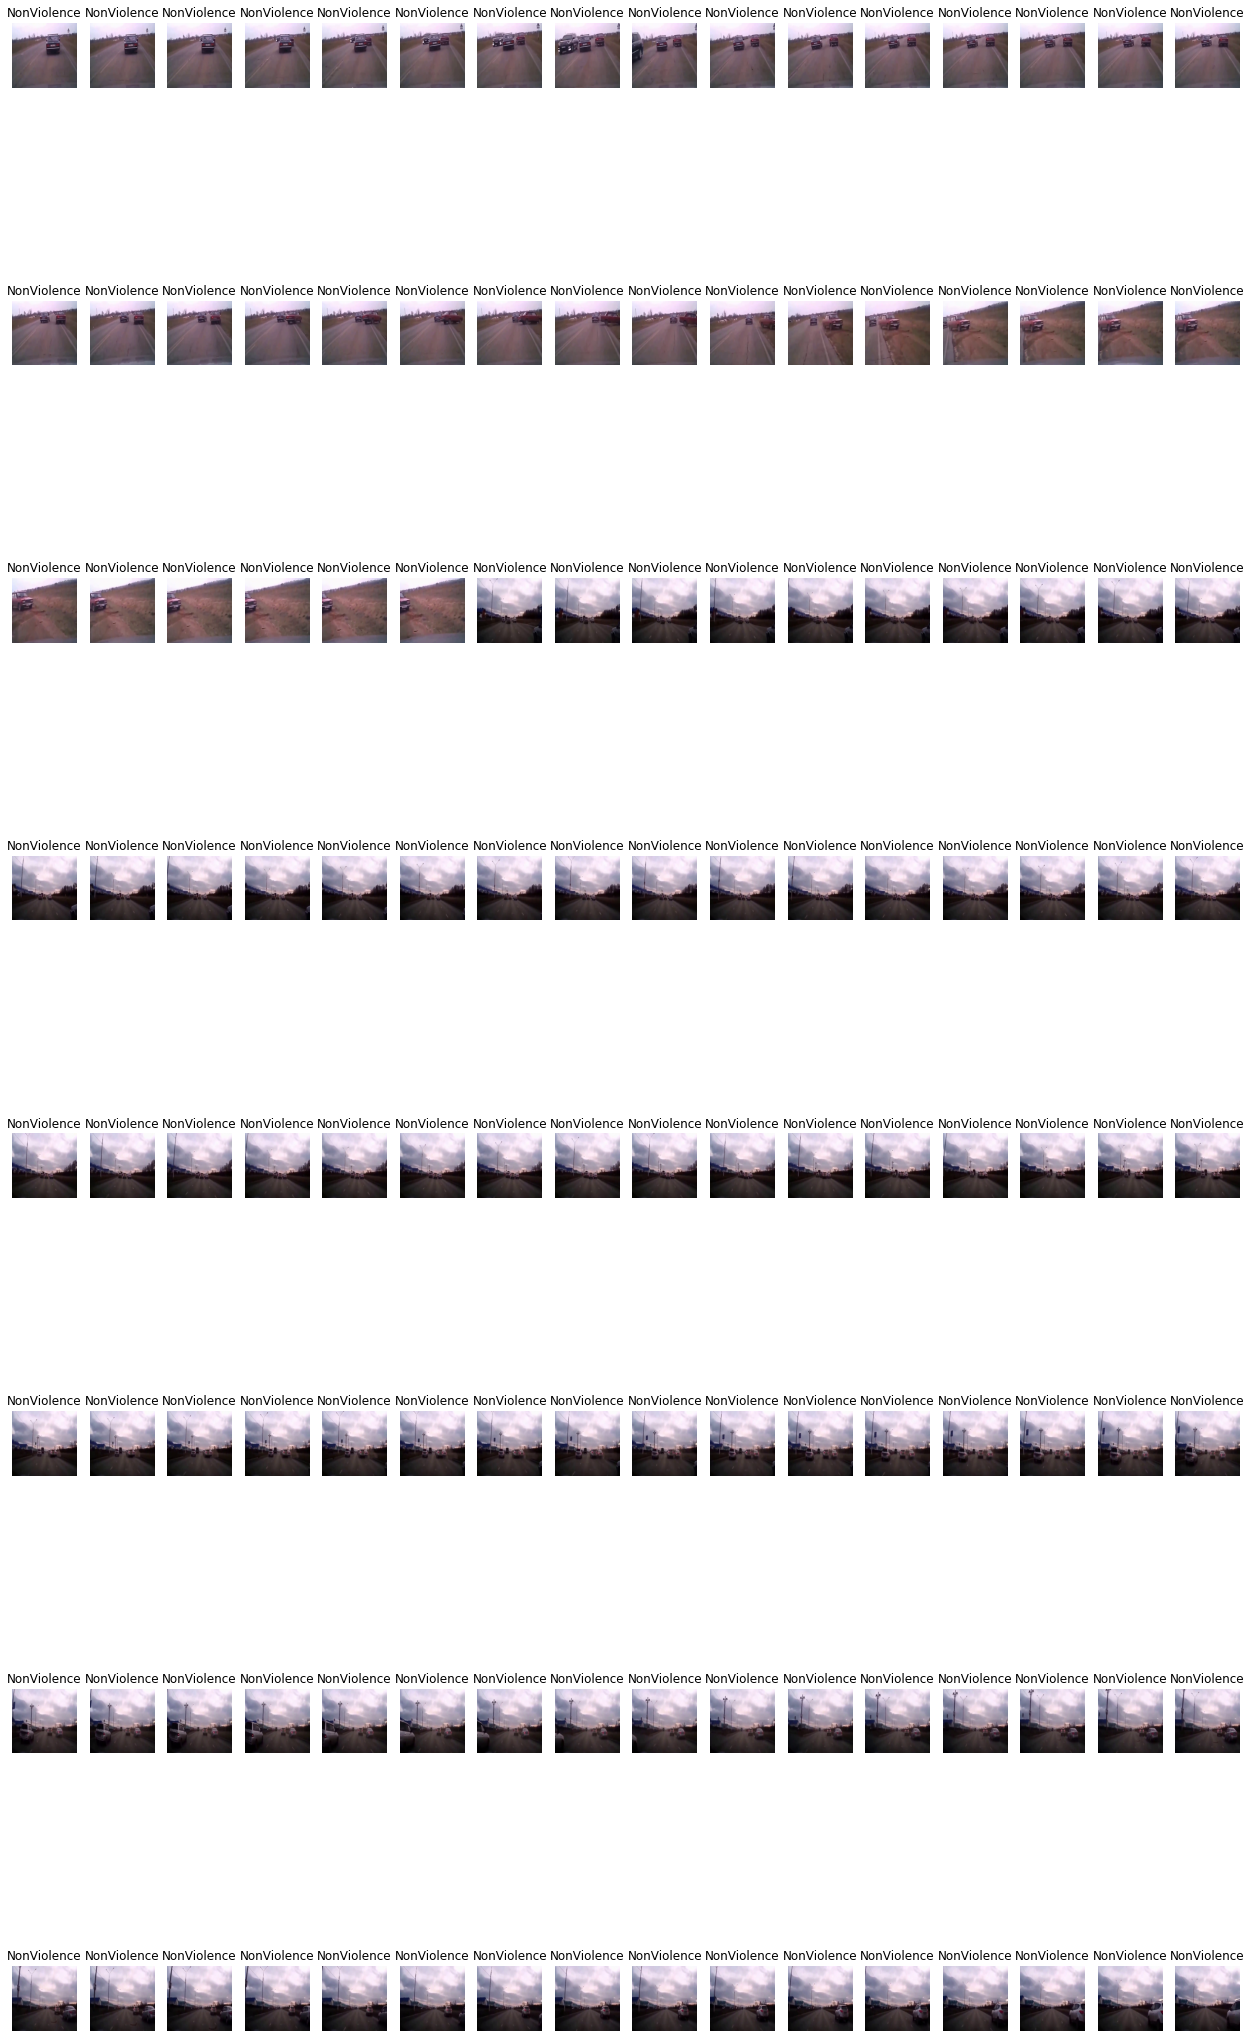

In [31]:
show_sample(test_dataset_only_rgb, index=1)

./EXTRA2/flow/test/v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0_flows.npy
./EXTRA2/flow/test/v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0_flows.npy
./EXTRA2/flow/test/v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0_flows.npy
./EXTRA2/flow/test/v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0_flows.npy
./EXTRA2/flow/test/v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0_flows.npy
./EXTRA2/flow/test/v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0_flows.npy
./EXTRA2/flow/test/v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0_flows.npy
./EXTRA2/flow/test/v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0_flows.npy
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'
'v=iHuggczItBk__#00-03-00_00-03-55_label_B6-0-0'


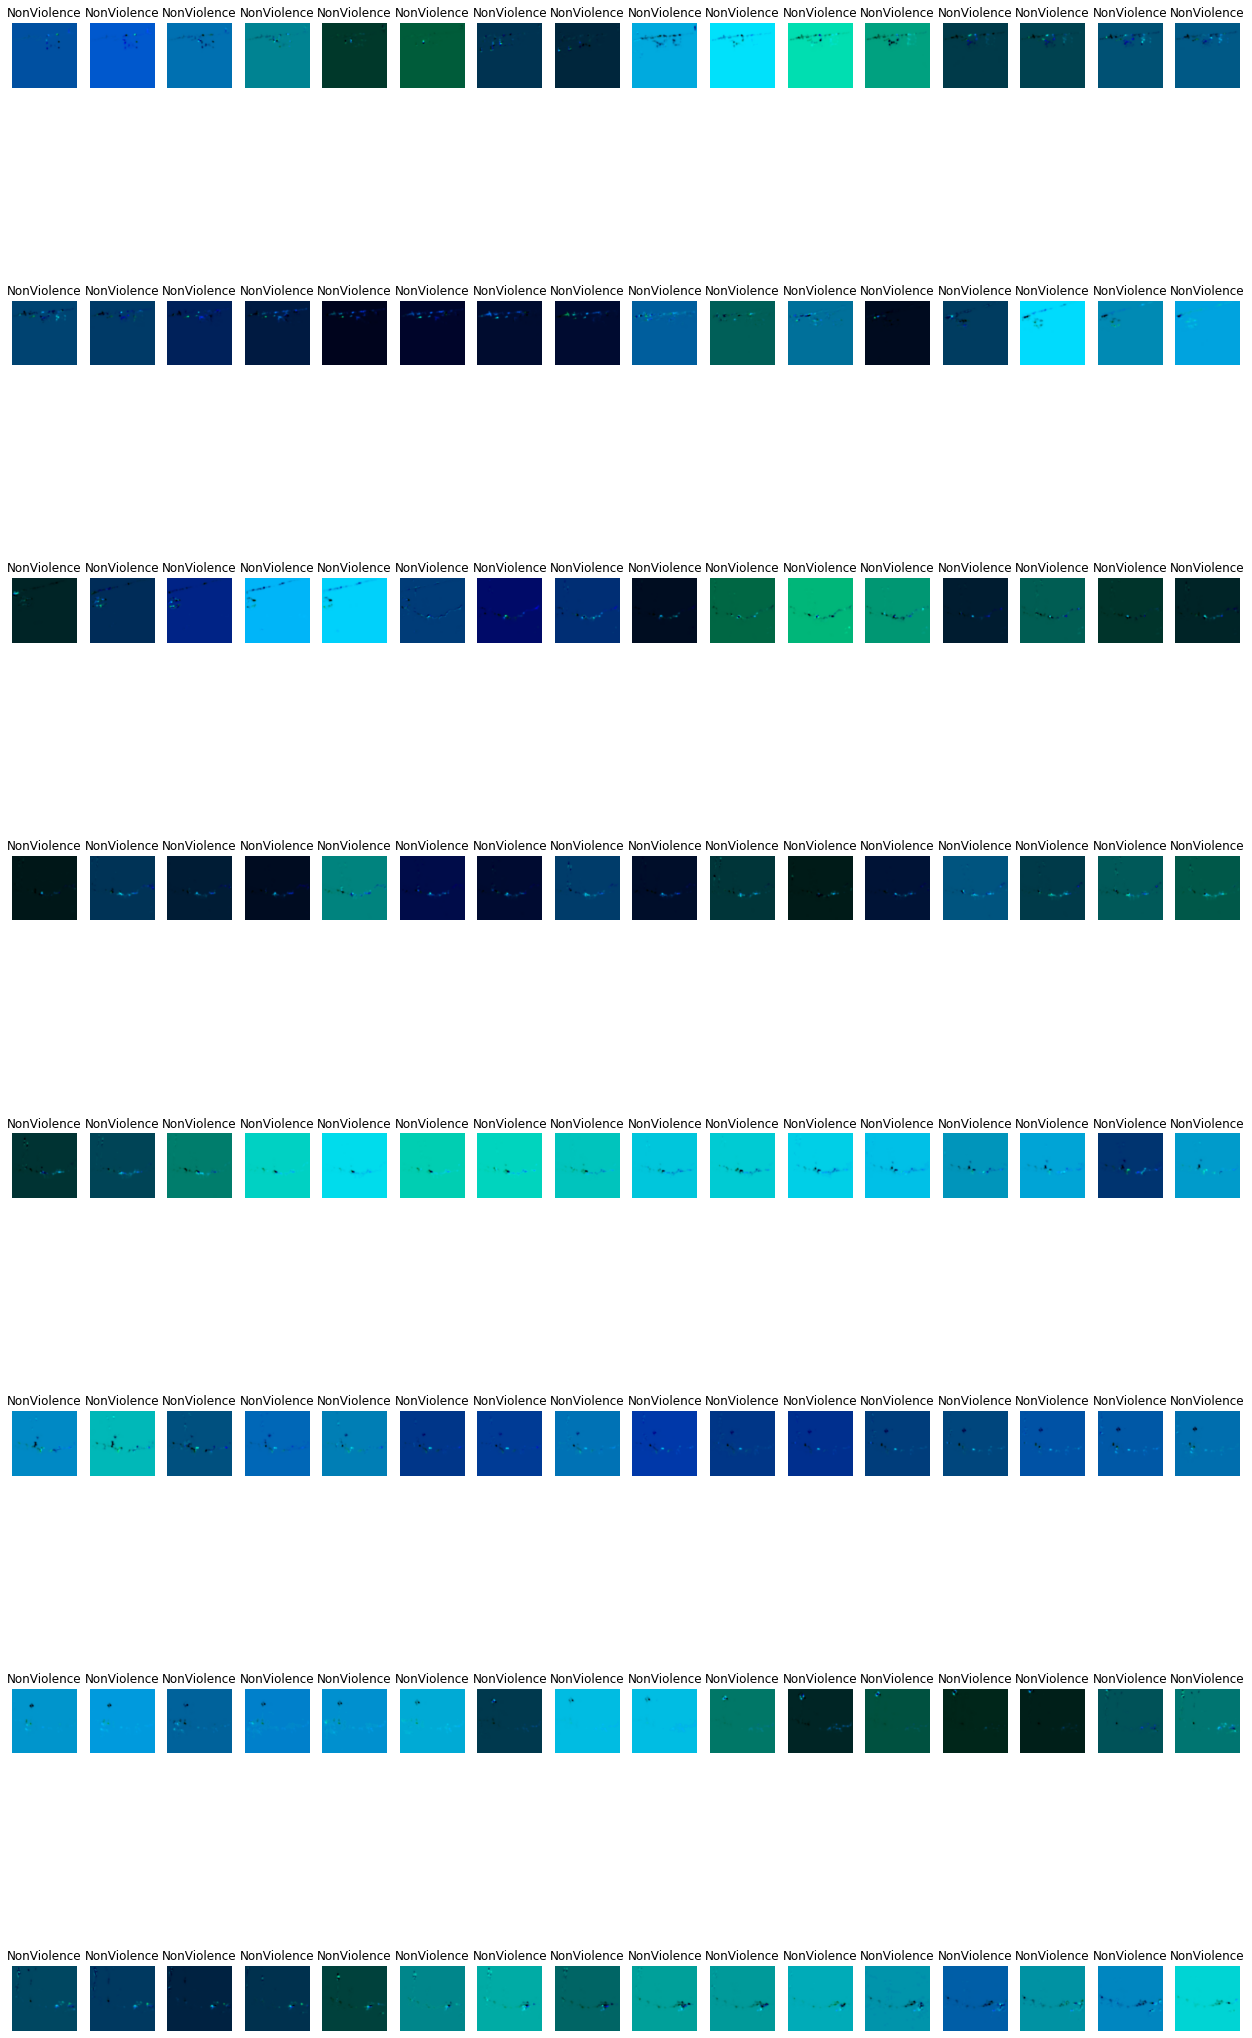

In [32]:
show_sample(test_dataset_only_flows, index=1)

# Train

In [33]:
def get_callbacks_model(save_history=True, save_model_per_epoch=True,
                        print_process=True, save_weights=False, 
                        type_model="rgb", monitor='val_accuracy'):
  """
  Get callbacks for fit
  
  - save_history: bool, save the fitting progress (loss, accuracy, validation_loss and accuracy_loss)
                  in csv file
  - save_model_per_epoch: bool, save the model on each epoch
  - print_process: bool, print on validation when the batch is ended
  - save_weights: bool, save the weights on each epoch
  """
  
  callbacks = []
  now = datetime.now()
  dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")

  if save_history:
    curr_history_folder = f'{HISTORY_FOLDER}/{type_model}/{dt_string}'
    ensure_folder_exists(curr_history_folder)
    
    csv_logger = tf.keras.callbacks.CSVLogger(curr_history_folder+"/history.csv", append=True)
    callbacks.append(csv_logger)
  
  if save_model_per_epoch:
    curr_checkpoint_folder = f'{CHECKPOINT_FOLDER}/{type_model}/{dt_string}'
    ensure_folder_exists(curr_checkpoint_folder)
    
    checkpointer = tf.keras.callbacks.ModelCheckpoint(
      filepath=curr_checkpoint_folder+"/model_{epoch:02d}_{accuracy:.2f}.h5",
      save_weights_only=False,
      monitor=monitor,
      mode='auto',
      save_freq='epoch',
      save_best_only=False,
      verbose=1)
    callbacks.append(checkpointer)

  if print_process:
    class ReportValidationStatus(tf.keras.callbacks.Callback):

        def on_test_batch_begin(self, batch, logs=None):
            print('Evaluating: batch {} begins at {}'.format(batch, datetime.now().time()))

        def on_test_batch_end(self, batch, logs=None):
            print('Evaluating: batch {} ends at {}'.format(batch, datetime.now().time()))
    callbacks.append(ReportValidationStatus())
  
  if save_weights:
    curr_checkpoint_folder = f'{CHECKPOINT_FOLDER}/{type_model}/{dt_string}'
    ensure_folder_exists(curr_checkpoint_folder)
    
    weightsaver = model.save_weights(curr_checkpoint_folder+
                                     "/weights_{epoch:02d}_{accuracy:.2f}")
    callbacks.append(weightsaver)

  return callbacks

In [40]:
rgb_model = get_visual_model(
  input_shape=(violent_generator_rgb.sliding_window, 224, 224, 3), 
  num_classes=len(violent_generator_rgb.dataset_labels)
)

rgb_model.summary()

Model: "i3d_with_top"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 16, 224, 224 0                                            
__________________________________________________________________________________________________
Conv3d_1a_7x7_conv (Conv3D)     (None, 8, 112, 112,  65856       input_6[0][0]                    
__________________________________________________________________________________________________
Conv3d_1a_7x7_bn (BatchNormaliz (None, 8, 112, 112,  192         Conv3d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv3d_1a_7x7 (Activation)      (None, 8, 112, 112,  0           Conv3d_1a_7x7_bn[0][0]           
_______________________________________________________________________________________

In [36]:
  flow_model = get_visual_model(
    input_shape=(violent_generator_flows.sliding_window, 224, 224, 2), 
    num_classes=len(violent_generator_flows.dataset_labels), 
    type_model='flow')

In [85]:
rgb_model = load_model(CHECKPOINT_FOLDER+'/rgb/31-05-2021_21-08-18/model_26_0.73.h5')
flow_model = load_model(CHECKPOINT_FOLDER+'/flow/26-05-2021_16-16-13/model_28_0.67.h5')

# rgb_model = get_visual_model(
#   input_shape=(violent_generator_rgb.sliding_window, 224, 224, 3), 
#   num_classes=len(violent_generator_rgb.dataset_labels),
#   with_top=False
# )

# flow_model = get_visual_model(
#   input_shape=(violent_generator_flows.sliding_window, 224, 224, 2), 
#   num_classes=len(violent_generator_flows.dataset_labels), 
#   type_model='flow',
#   with_top=False)

rgb_flow_model = concate_two_models(
  rgb_model=rgb_model, 
  flow_model=flow_model, 
  classes=len(violent_generator_rgb.dataset_labels))

rgb_flow_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16, 224, 224 0                                            
__________________________________________________________________________________________________
input_1_flow (InputLayer)       [(None, 16, 224, 224 0                                            
__________________________________________________________________________________________________
Conv3d_1a_7x7_conv (Conv3D)     (None, 8, 112, 112,  65856       input_3[0][0]                    
__________________________________________________________________________________________________
Conv3d_1a_7x7_conv_flow (Conv3D (None, 8, 112, 112,  43904       input_1_flow[0][0]               
____________________________________________________________________________________________

## Main

In [ ]:
with tf.device('/device:GPU:0'):
  callbacks = get_callbacks_model()
  rgb_model = load_model(CHECKPOINT_FOLDER+'/rgb/25-05-2021_22-06-22/model_09_0.67.h5')

  # Train model on dataset
  history = rgb_model.fit(violent_generator_rgb,
                          verbose=1,
                          epochs=30, 
                          batch_size=violent_generator_rgb.batch_size, 
                          validation_data=violent_generator_rgb.get_validation_generator(),
                          validation_steps=500, 
                          steps_per_epoch=1000,
#                           validation_steps=len(test_dataset) // test_dataset.batch_size, 
#                           steps_per_epoch=len(violent_generator_rgb) // violent_generator_rgb.batch_size, 
                          callbacks=[callbacks])


In [ ]:
with tf.device('/device:GPU:0'):
  callbacks = get_callbacks_model(type_model='flow')
#   flow_model = load_model(CHECKPOINT_FOLDER+'/flow/09-05-2021_07-47-40/model_20_0.59.h5')

  # Train model on dataset
  history = flow_model.fit(violent_generator_flows,
                          verbose=1,
                          epochs=30, 
                          batch_size=violent_generator_flows.batch_size, 
                          validation_data=violent_generator_flows.get_validation_generator(),
                          validation_steps=200, 
                          steps_per_epoch=500,
#                           validation_steps=len(test_dataset) // test_dataset.batch_size, 
#                           steps_per_epoch=len(violent_generator_rgb) // violent_generator_rgb.batch_size, 
                          callbacks=[callbacks])


In [ ]:
with tf.device('/device:GPU:0'):
  callbacks = get_callbacks_model(monitor="accuracy",type_model='combined')

  # Train model on dataset
  history = rgb_flow_model.fit(test_dataset,
                          verbose=1,
                          epochs=30, 
                          batch_size=vide_dataset.batch_size, 
                          steps_per_epoch=10,
#                           validation_steps=len(test_dataset) // test_dataset.batch_size, 
#                           steps_per_epoch=len(violent_generator_rgb) // violent_generator_rgb.batch_size, 
                          callbacks=[callbacks])


## Graphs

In [42]:
def print_loss_and_acc(date, model:str ='rgb', has_val=True):
  history_data = pd.read_csv(f'{HISTORY_FOLDER}/{model}/{date}/history.csv',
                             sep=',',
                             engine='python')
  # summarize history for loss
  print('loss')
  metrics = history_data
  if has_val:
    plt.plot(history_data.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
  else:
    plt.plot(history_data.epoch, metrics['loss'])
    plt.legend(['loss'])
  plt.show()
  
  # summarize history for accuracy
  print('categorical_accuracy')
  metrics = history_data
  if has_val:
    plt.plot(history_data.epoch, metrics['accuracy'], metrics['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
  else:
    plt.plot(history_data.epoch, metrics['accuracy'])
    plt.legend(['accuracy'])
  plt.show()

loss


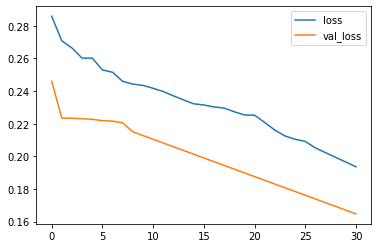

categorical_accuracy


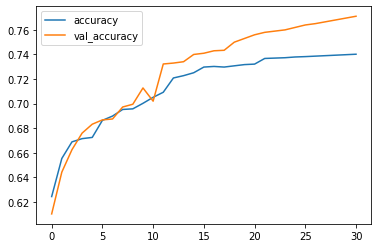

In [86]:
print_loss_and_acc(date='last')

loss


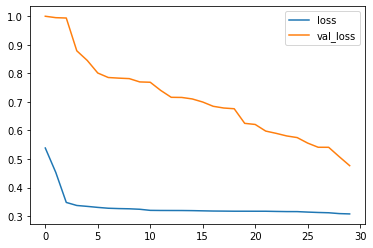

categorical_accuracy


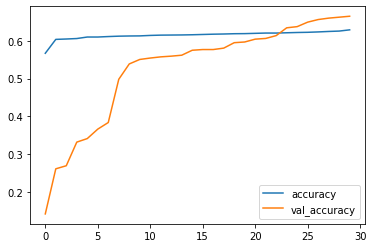

In [87]:
print_loss_and_acc(date='last', model='flow')

# Test

In [52]:
with tf.device('/GPU:0'):
  rgb_model = load_model(CHECKPOINT_FOLDER+'/rgb/24-04-2021_08-32-19/model_23_0.74.h5')
  flow_model = load_model(CHECKPOINT_FOLDER+'/flow/17-05-2021_17-22-04/model_06_0.63.h5')

In [67]:
video_dataset_labels = {0: 'NonViolence',
                        1: 'Fighting',
                        2: 'Gun/Gunshot',
                        3: 'Riot/Crowded',
                        4: 'Abuse',
                        5: 'Car accident',
                        6: 'Explosion/Fire/Smoke'}

In [ ]:
for batch_count, (rgb, flow, label) in enumerate(test_dataset):
  for i in range(test_dataset.batch_size):
    rgb_expand = tf.expand_dims(rgb[i], axis=0)
    rgb_logits = rgb_model.predict(rgb_expand)
    
    flow_expand = tf.expand_dims(flow[i], axis=0)
    flow_logits = flow_model.predict(flow_expand)
    sample_logits = rgb_logit+flow_logits

    # produce softmax output from model logit for class probabilities
    sample_logits = sample_logits[0]  # we are dealing with just one example
    
    sample_predictions = softmax(sample_logits)
    sorted_indices = np.argsort(sample_predictions)[::-1]
    print(f'{i} --> {label[i]}')

    for index in sorted_indices:
      print(f'{i} --> {sample_predictions[index]}', sample_logits[index], test_dataset.dataset_labels_names[index])
    print("--------")

In [ ]:
video_path='./Visual/XD-Violence/videos/test/Bullet.in.the.Head.1990__#02-02-00_02-05-22_label_B2-B6-G.mp4'
curr_fps=5

rgb, flow = video_to_npy(video_path, fps=curr_fps)
video_name=get_video_name(video_path)
video_label=violent_generator_rgb.get_video_labels(video_name)

for i in range(math.ceil(len(rgb)/SLIDING_WINDOW)):
  rgb_selected = select_frames(rgb, i)
  rgb_expand = tf.expand_dims(rgb_selected, axis=0)
  rgb_logits = rgb_model.predict(rgb_expand)
  
  flow_selected = select_frames(flow, i)
  flow_expand = tf.expand_dims(flow_selected, axis=0)
  flow_logits = flow_model.predict(flow_expand)
  
  sample_logits = rgb_logits+flow_logits
  # produce softmax output from model logit for class probabilities
  sample_logits = sample_logits[0]  # we are dealing with just one example
  
  sample_predictions = softmax(sample_logits)
  sorted_indices = np.argsort(sample_predictions)[::-1]

  for index in sorted_indices:
    print(f'{get_seconds(video_path, curr_fps,SLIDING_WINDOW,i)} --> {sample_predictions[index]}', sample_logits[index], test_dataset.dataset_labels_names[index])
  print("--------")